In [1]:
import get_data
from preprocess import preprocess, one_hot
from synthetic_data_generate import advanced_augmentation
from data_utils import create_dataloaders, TestDataset
from train_validate import train, validate
from main import synth_data
import os
import json

from models import BaseModel, SexBasedModel, BrightnessBasedModel

import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import transforms
from PIL import Image

c:\Users\phili\miniconda3\envs\MLS_1\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:

train_dataset_path = "data/train_images"
synth_dir = "data/synthetic_images"

data_model = [

     ['base_all', BaseModel(num_tabular_features=9), 0, False],
     ['base_small', BaseModel(num_tabular_features=9), 0, True],
     ['base_small_3xaug', BaseModel(num_tabular_features=9), 3, True],
     ['base_small_5xaug', BaseModel(num_tabular_features=9), 5, True],
     ['sex_based_all', SexBasedModel(num_tabular_features=9), 0, False],
     ['sex_based_small', SexBasedModel(num_tabular_features=9), 0, True],
     ['sex_based_small_3xaug', SexBasedModel(num_tabular_features=9), 3, True],
     ['sex_based_small_5xaug', SexBasedModel(num_tabular_features=9), 5, True],
     ['brightness_based_all', BrightnessBasedModel(num_tabular_features=9), 0, False],
     ['brightness_based_small', BrightnessBasedModel(num_tabular_features=9), 0, True],
     ['brightness_based_small_3xaug', BrightnessBasedModel(num_tabular_features=9), 3, True],
     ['brightness_based_small_5xaug', BrightnessBasedModel(num_tabular_features=9), 5, True]
    ]


_, val_data, _ = preprocess()
train_data, _,_ = preprocess(smaller=True)

val_data = val_data[~val_data['image_name'].isin(train_data['image_name'])]


# need to make sure the models are validated on the same data for comparison and that all overlaps are removed
for data, model, num_augmentations, small in data_model:
    
  
    train_data, _, test_data = preprocess(smaller=small)
    
    model_dir = f'saved_models/{data}'

    # Create synthetic images directory if it doesn't exist
    os.makedirs(synth_dir, exist_ok=True)

    # Count existing synthetic images
    synthetic_files = len([f for f in os.listdir(train_dataset_path) if os.path.isfile(os.path.join(train_dataset_path, f))])
    expected_synthetic_files = len(train_data) * (num_augmentations + 1)


    synthetic_dataset = synth_data(train_data, num_augmentations)

    advanced_augmentation(train_dataset_path, synth_dir, train_data, augmentations_per_image=num_augmentations)

    # Move synthetic images to train images folder
    print("Moving synthetic images to train folder...")
    synth_image_files = [f for f in os.listdir(synth_dir) if os.path.isfile(os.path.join(synth_dir, f))]
    for file in synth_image_files:
        src_path = os.path.join(synth_dir, file)
        dst_path = os.path.join(train_dataset_path, file)
        if not os.path.exists(dst_path):  # Avoid overwriting existing files
            os.rename(src_path, dst_path)  # Move file (rename operation)
    print(f"Moved {len(synth_image_files)} synthetic images to training directory")
        

    train_data_new, val_data_new, test_data_new = one_hot(synthetic_dataset, val_data, test_data)
    
    model_path = f"{model_dir}/best_model.pth"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)


    # Define hyperparameters
    batch_size = 64
    criterion = torch.nn.BCELoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tabular_features = train_data_new.columns[2:-1].to_list()
    train_loader, val_loader = create_dataloaders(train_data_new, val_data_new, train_dataset_path, 
                       img_id_column='image_name',
                       target_column='target',
                       tabular_columns=tabular_features,
                       batch_size=batch_size
                       )
    
    final_val_stats = validate(model, val_loader, criterion, device)
    
    with open(os.path.join(model_dir, 'val_results.json'), 'w') as f:
            json.dump(final_val_stats, f, indent=4)
    
    print(f"Finished {data}")




Moving synthetic images to train folder...
Moved 91508 synthetic images to training directory
Applying one-hot encoding to categorical features...
After encoding: train_data has 12 features, val_data has 12 features


C:\Users\phili\AppData\Local\Temp\ipykernel_7976\2430601101.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
c:\Users\phili\miniconda

Finished brightness_based_all
Moving synthetic images to train folder...
Moved 91508 synthetic images to training directory
Applying one-hot encoding to categorical features...
After encoding: train_data has 12 features, val_data has 12 features


C:\Users\phili\AppData\Local\Temp\ipykernel_7976\2430601101.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Finished brightness_based_small
Generating synthetic images...
Generated 753 advanced augmented images in data/synthetic_images
Moving synthetic images to train folder...
Moved 92261 synthetic images to training directory
Applying one-hot encoding to categorical features...
After encoding: train_data has 12 features, val_data has 12 features


C:\Users\phili\AppData\Local\Temp\ipykernel_7976\2430601101.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Finished brightness_based_small_3xaug
Generating synthetic images...
Generated 2453 advanced augmented images in data/synthetic_images
Moving synthetic images to train folder...
Moved 94477 synthetic images to training directory
Applying one-hot encoding to categorical features...
After encoding: train_data has 12 features, val_data has 12 features


C:\Users\phili\AppData\Local\Temp\ipykernel_7976\2430601101.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
c:\Users\phili\miniconda

Finished brightness_based_small_5xaug


In [11]:
from data_utils import TestDataset

In [ ]:
len

In [24]:
# Load the model
from data_utils import TestDataset
import json
test_df = pd.read_csv('data/test.csv')
test_data = test_df.apply(lambda x: x.fillna(method='ffill').fillna(method='bfill') if x.isnull().any() else x)

synthetic_dataset, val_data, _ = preprocess(smaller=True)
_, _, test_data_new = one_hot(synthetic_dataset, val_data, test_data)
saved_models_dir = "saved_models"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = os.path.join(saved_models_dir, "base_all", "best_model.pth")
model = BaseModel(num_tabular_features=9)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()


 # Get tabular features (all columns except image_name)
tabular_features = test_data_new.columns[2:-3].to_list()
test_dataset_path = "data/test_images"

# Create test dataset and dataloader
test_dataset = TestDataset(test_data_new, test_dataset_path, 'image_name', tabular_features)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    

# Generate predictions
all_probabilities = []
all_targets = []
all_image_names = []

with torch.no_grad():
    for batch in test_loader:
        images, tabular_data = batch
        images, tabular_data = images.to(device), tabular_data.to(device)
        
        outputs = model(images, tabular_data)
        probabilities = outputs.squeeze().cpu().numpy()
        
        all_probabilities.extend(probabilities)
        

# Apply the threshold to generate predictions
predictions = (np.array(all_probabilities) >= 0.28).astype(int)


# Get image names as a list from the dataframe
image_names = test_data_new['image_name'].tolist()


results_dict = pd.DataFrame({
    'image_name': image_names,
    'target': [float(x) for x in all_probabilities]
})

results_dict.to_csv("test_predictions.csv", index=False)

print(f"Saved predictions for {len(predictions)} test images to test_predictions.csvjson")


C:\Users\phili\AppData\Local\Temp\ipykernel_7976\371392135.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_df.apply(lambda x: x.fillna(method='ffill').fillna(method='bfill') if x.isnull().any() else x)


Applying one-hot encoding to categorical features...
After encoding: train_data has 12 features, val_data has 12 features


C:\Users\phili\AppData\Local\Temp\ipykernel_7976\371392135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Saved predictions for 10982 test images to test_predictions.csvjson


In [23]:
results_dict = pd.DataFrame({
    'image_name': image_names,
    'target': [float(x) for x in all_probabilities]
})

results_dict.to_csv("test_predictions.csv", index=False)

print(f"Saved predictions for {len(predictions)} test images to test_predictions.csv")


Saved predictions for 10982 test images to test_predictions.csv


In [22]:
len(results_dict)

10982

In [20]:
test_df = pd.read_csv('data/test.csv')
test_data = test_df.apply(lambda x: x.fillna(method='ffill').fillna(method='bfill') if x.isnull().any() else x)


len(test_data)

C:\Users\phili\AppData\Local\Temp\ipykernel_7976\2826204853.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data = test_df.apply(lambda x: x.fillna(method='ffill').fillna(method='bfill') if x.isnull().any() else x)


10982

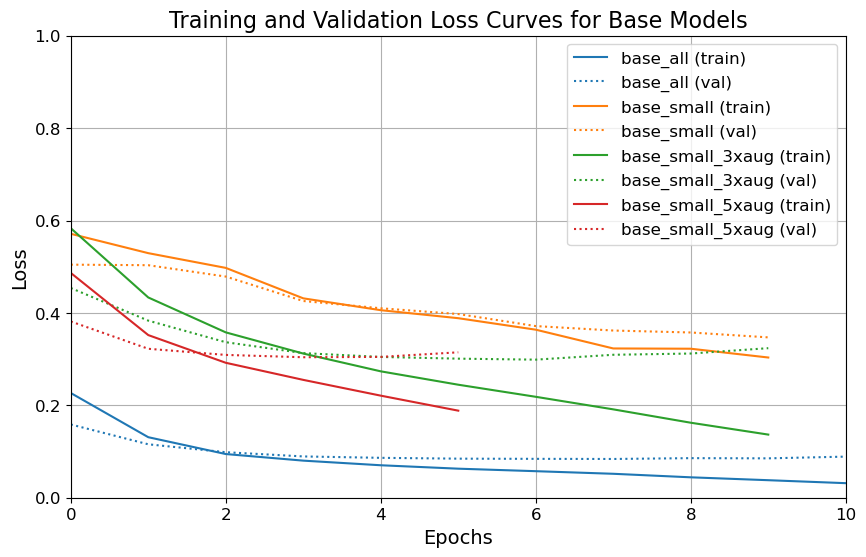

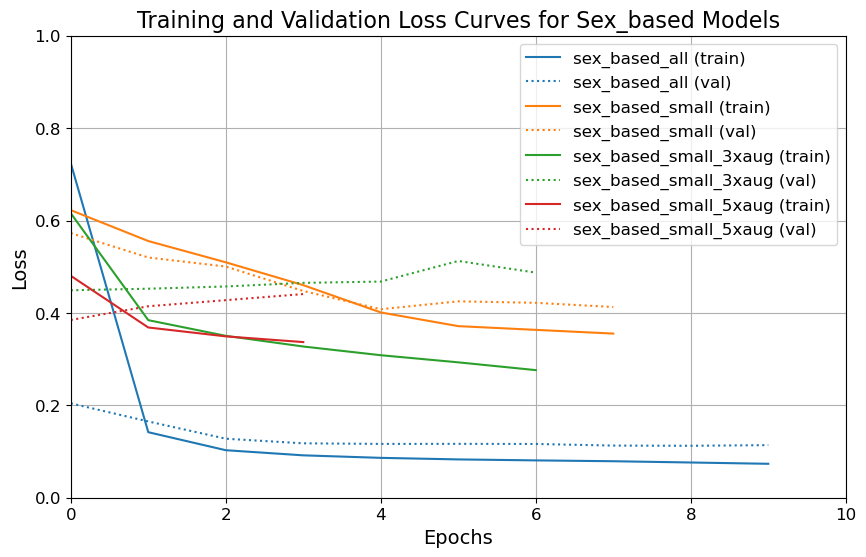

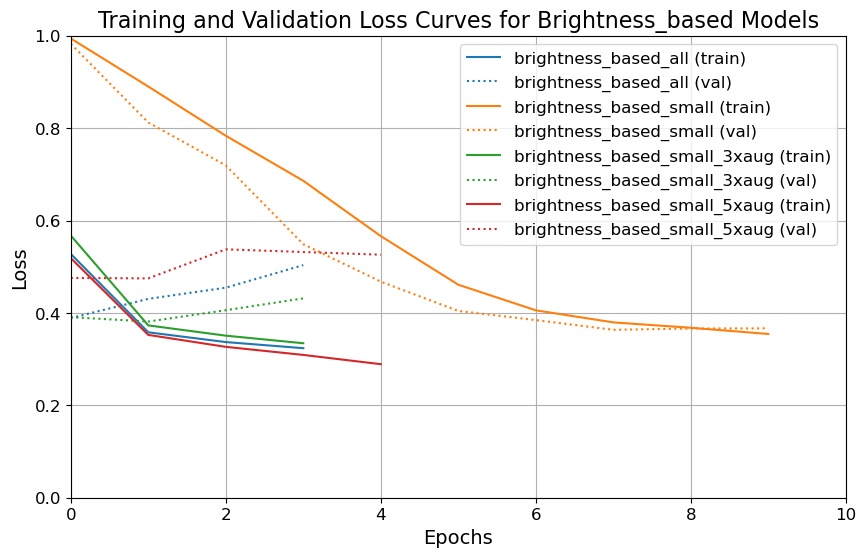

In [30]:
import os
import json

import matplotlib.pyplot as plt

# Directory containing the saved models
saved_models_dir = "saved_models"

# Initialize a dictionary to store training loss data
training_loss_data = {}
val_loss_data = {}

# Iterate through each model directory
for model_name in os.listdir(saved_models_dir):
    model_dir = os.path.join(saved_models_dir, model_name)
    history_file = os.path.join(model_dir, "history.json")
    
    # Check if the history.json file exists
    if os.path.isfile(history_file):
        with open(history_file, "r") as f:
            history = json.load(f)
            if "train_loss" in history:
                training_loss_data[model_name] = history["train_loss"]
                val_loss_data[model_name] = history["val_loss"]



# Separate training loss data by model type
model_types = {"base": {}, "sex_based": {}, "brightness_based": {}}

for model_name, train_loss in training_loss_data.items():
    for model_type in model_types.keys():
        if model_name.startswith(model_type):
            model_types[model_type][model_name] = train_loss
            break

# Plot training loss curves for each model type
for model_type, models in model_types.items():
    if models:  # Check if there are models of this type
        plt.figure(figsize=(10, 6))
        for model_name, train_loss in models.items():
            plt.plot(train_loss, label=f"{model_name} (train)")
            if model_name in val_loss_data:
                plt.plot(val_loss_data[model_name], linestyle='dotted', label=f"{model_name} (val)", color=plt.gca().lines[-1].get_color())
        plt.title(f"Training and Validation Loss Curves for {model_type.capitalize()} Models", fontsize=16)
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Loss", fontsize=14)
        plt.ylim(0, 1)  # Fix y-axis between 0 and 1
        plt.xlim(0, 10)  # Fix x-axis between 0 and 10
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

In [46]:
import pandas as pd
import os
import json

# Directory containing the saved models
saved_models_dir = "saved_models"

# Iterate through each model directory
for model_name in os.listdir(saved_models_dir):
    model_dir = os.path.join(saved_models_dir, model_name)
    val_results_file = os.path.join(model_dir, "val_results.json")
    
    # Check if the val_results.json file exists
    if os.path.isfile(val_results_file):
        with open(val_results_file, "r") as f:
            val_results = json.load(f)
        
        # Extract the relevant metrics
        metrics = {
            "Metric": ["F1-Score", "ROC-AUC", "Recall"],
            "Value": [
                val_results["advanced_metrics"]["f1"],
                val_results["advanced_metrics"]["roc_auc"],
                val_results["advanced_metrics"]["recall"]
            ]
        }
        
        # Create a DataFrame to display the metrics in a table
        metrics_df = pd.DataFrame(metrics)
        
        # Display the table
        print(f"Metrics for model: {model_name}")
        print(metrics_df)
        print("\n")

Metrics for model: base_all
     Metric     Value
0  F1-Score  0.055556
1   ROC-AUC  0.898505
2    Recall  0.032258


Metrics for model: base_small
     Metric     Value
0  F1-Score  0.080808
1   ROC-AUC  0.868348
2    Recall  0.258065


Metrics for model: base_small_3xaug
     Metric     Value
0  F1-Score  0.082353
1   ROC-AUC  0.855973
2    Recall  0.225806


Metrics for model: base_small_5xaug
     Metric     Value
0  F1-Score  0.082840
1   ROC-AUC  0.834412
2    Recall  0.225806


Metrics for model: brightness_based_all
     Metric     Value
0  F1-Score  0.000000
1   ROC-AUC  0.482813
2    Recall  0.000000


Metrics for model: brightness_based_small
     Metric     Value
0  F1-Score  0.000000
1   ROC-AUC  0.673913
2    Recall  0.000000


Metrics for model: brightness_based_small_3xaug
     Metric     Value
0  F1-Score  0.000000
1   ROC-AUC  0.464428
2    Recall  0.000000


Metrics for model: brightness_based_small_5xaug
     Metric     Value
0  F1-Score  0.000000
1   ROC-AUC  0.456

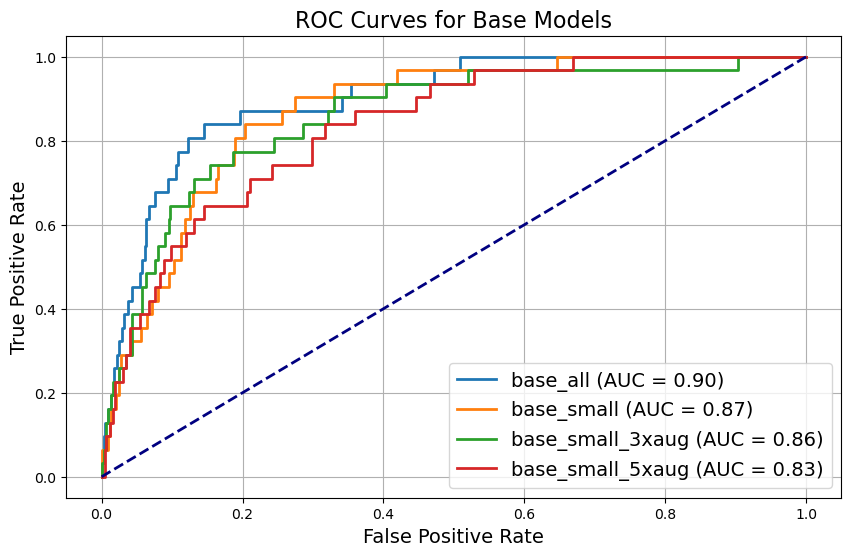

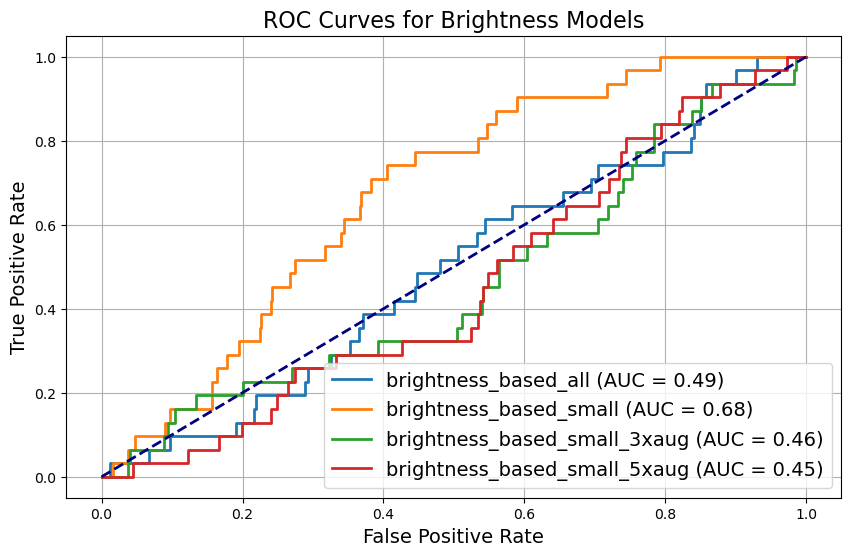

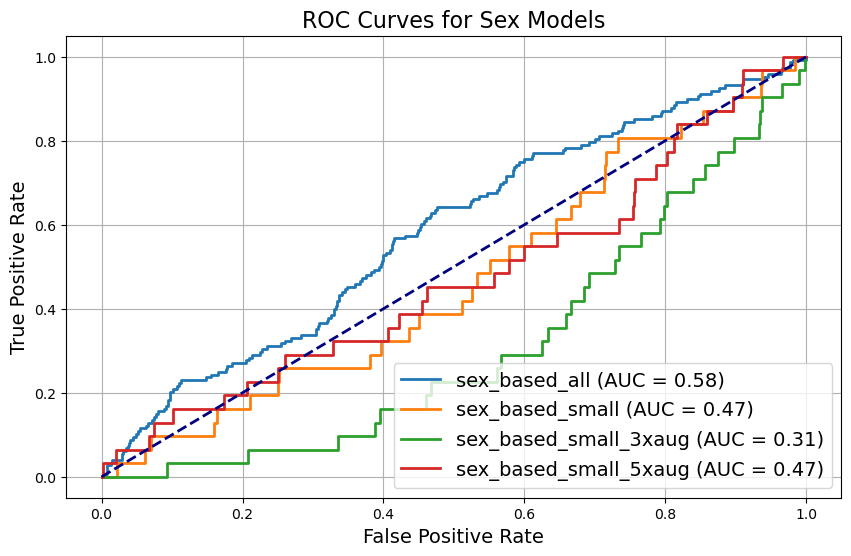

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Group models by type
model_types = {"base": {}, "brightness": {}, "sex": {}}

# Iterate through each model directory
for model_name in os.listdir(saved_models_dir):
    model_dir = os.path.join(saved_models_dir, model_name)
    val_results_file = os.path.join(model_dir, "val_results.json")
    
    # Check if the val_results.json file exists
    if os.path.isfile(val_results_file):
        with open(val_results_file, "r") as f:
            val_results = json.load(f)
        
        # Extract ROC data
        roc_data = val_results["advanced_metrics"]["roc_curve"]
        fpr = roc_data["fpr"]
        tpr = roc_data["tpr"]
        roc_auc = auc(fpr, tpr)
        
        # Determine model type and store ROC data
        for model_type in model_types.keys():
            if model_name.startswith(model_type):
                model_types[model_type][model_name] = (fpr, tpr, roc_auc)
                break

# Plot ROC curves for each model type
for model_type, models in model_types.items():
    if models:  # Check if there are models of this type
        plt.figure(figsize=(10, 6))
        for model_name, (fpr, tpr, roc_auc) in models.items():
            plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.title(f"ROC Curves for {model_type.capitalize()} Models", fontsize=16)
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.legend(loc="lower right", fontsize=14)
        plt.grid(True)
        plt.show()

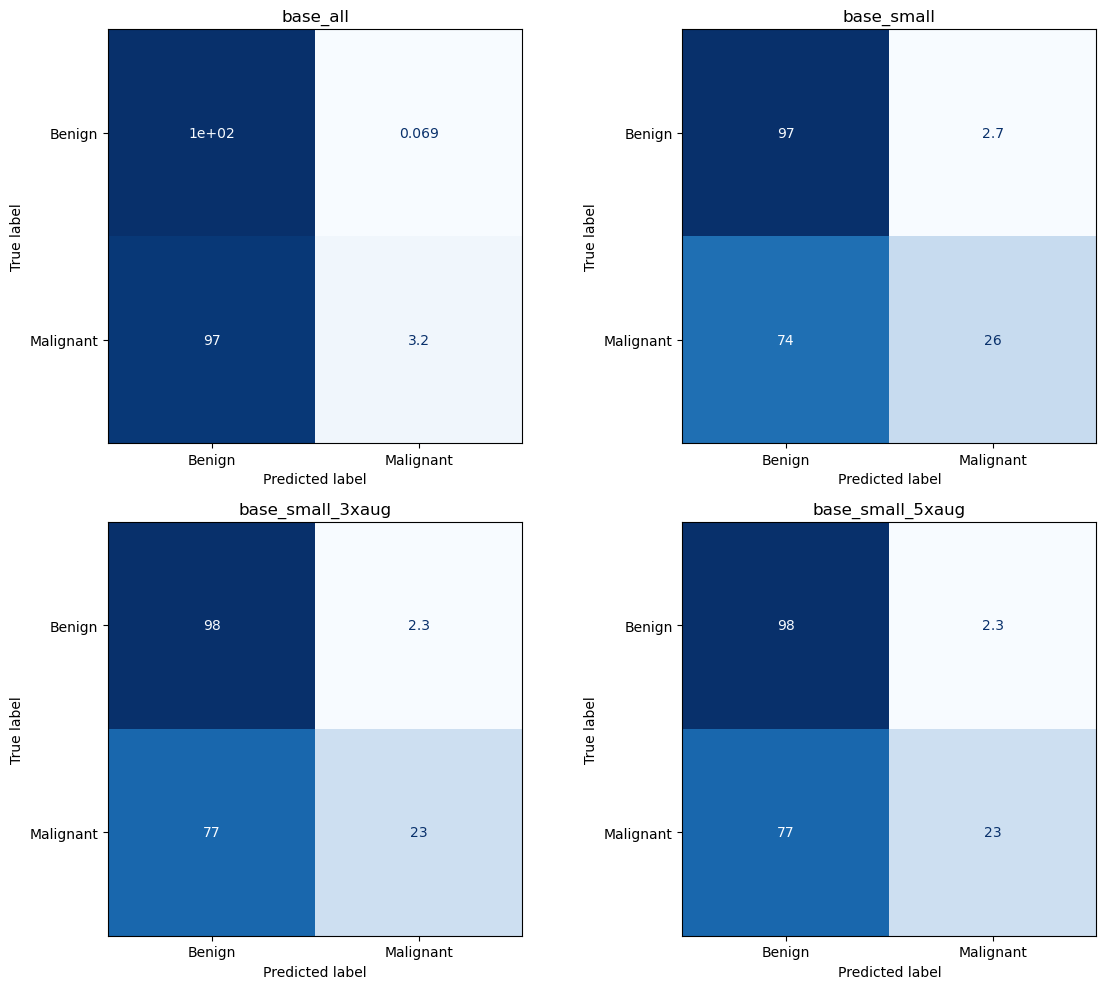

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Extract confusion matrices for base models
base_models = ["base_all", "base_small", "base_small_3xaug", "base_small_5xaug"]
confusion_matrices = {}

for model_name in base_models:
    if model_name in val_loss_data:
        val_results_file = os.path.join(saved_models_dir, model_name, "val_results.json")
        if os.path.isfile(val_results_file):
            with open(val_results_file, "r") as f:
                val_results = json.load(f)
                confusion_matrices[model_name] = val_results["advanced_metrics"]["confusion_matrix"]

# Plot confusion matrices in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for idx, model_name in enumerate(base_models):
    if model_name in confusion_matrices:
        cm = np.array(confusion_matrices[model_name])  # Convert to NumPy array
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["Benign", "Malignant"])
        disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
        axes[idx].set_title(model_name)
        axes[idx].set_xlabel("Predicted label")
        axes[idx].set_ylabel("True label")

plt.tight_layout()
plt.show()

Best Threshold: 0.26
Best F1 Score: 0.12121212121212123


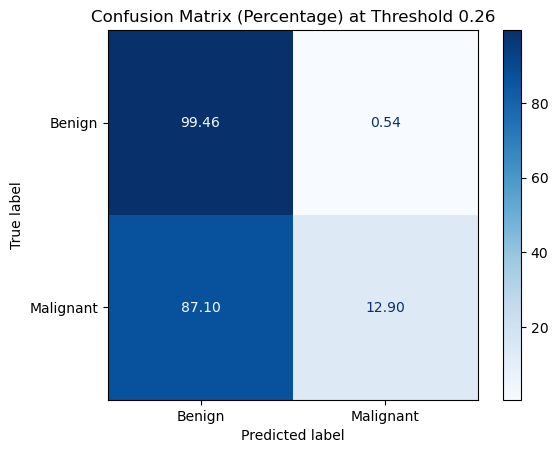

In [49]:
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt
# Extract probabilities and targets for the base_all model
val_results_file = os.path.join(saved_models_dir, "base_all", "val_results.json")
with open(val_results_file, "r") as f:
    val_results = json.load(f)

probabilities = np.array(val_results["probabilities"])
targets = np.array(val_results["targets"])

# Initialize variables to track the best threshold and F1 score
best_threshold = 0.0
best_f1 = 0.0
best_predictions = None

# Iterate over thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.01, 0.01)
for threshold in thresholds:
    predictions = (probabilities >= threshold).astype(int)
    tp = np.sum((predictions == 1) & (targets == 1))
    fp = np.sum((predictions == 1) & (targets == 0))
    fn = np.sum((predictions == 0) & (targets == 1))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_predictions = predictions

    # Use the best threshold to calculate the confusion matrix
    predictions = (probabilities >= best_threshold).astype(int)
    cm = confusion_matrix(targets, predictions)


# Initialize variables to track the best threshold and F1 score

# Print the best threshold and F1 score
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")

# Plot the confusion matrix as a percentage of true labels for the best threshold
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["Benign", "Malignant"])
disp.plot(cmap="Blues", values_format=".2f")
plt.title(f"Confusion Matrix (Percentage) at Threshold {best_threshold}")
plt.show()

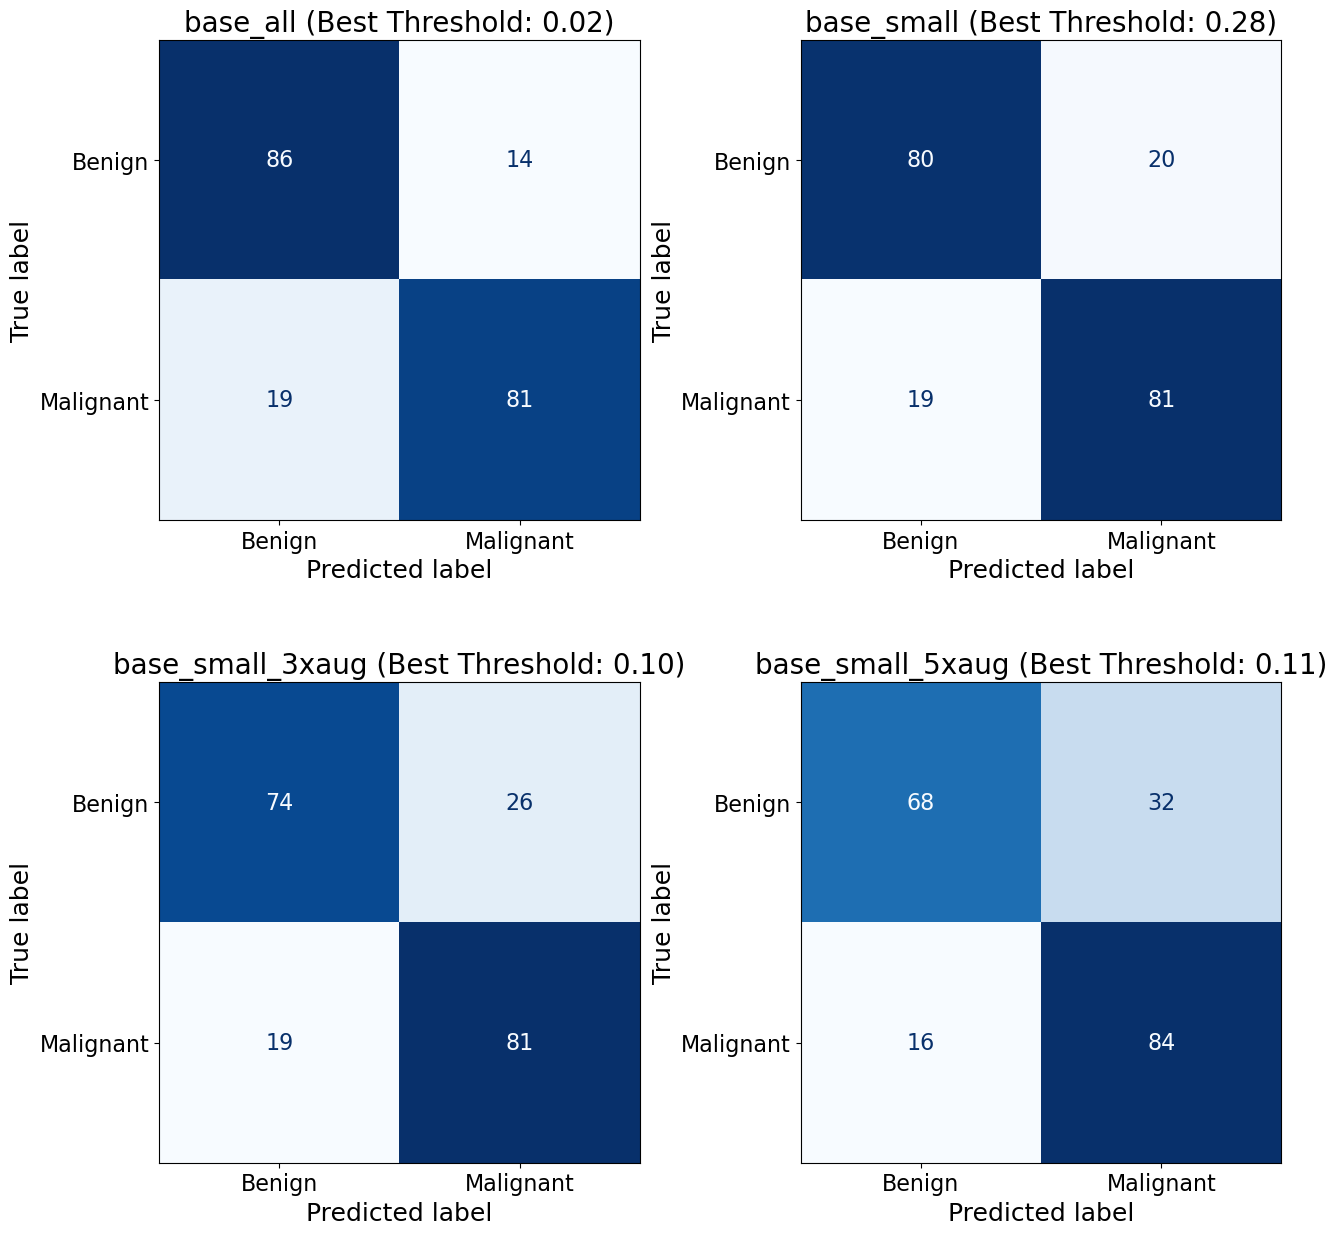

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


# Extract confusion matrices for all base models
confusion_matrices = {}
best_thresholds = {}
for model_name in base_models:
    val_results_file = os.path.join(saved_models_dir, model_name, "val_results.json")
    if os.path.isfile(val_results_file):
        with open(val_results_file, "r") as f:
            val_results = json.load(f)
            probabilities = np.array(val_results["probabilities"])
            targets = np.array(val_results["targets"])
            
            # Initialize variables to track the best threshold and F1 score
            best_threshold = 0.0
            best_f1 = 0.0
            
            # Iterate over thresholds from 0.0 to 1.0 with a step of 0.01
            thresholds = np.arange(0.0, 1.01, 0.01)
            for threshold in thresholds:
                predictions = (probabilities >= threshold).astype(int)
                tp = np.sum((predictions == 1) & (targets == 1))
                fp = np.sum((predictions == 1) & (targets == 0))
                fn = np.sum((predictions == 0) & (targets == 1))
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                if 0.8 <= recall <= 0.9 and f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
            # Use the best threshold to calculate the confusion matrix
            predictions = (probabilities >= best_threshold).astype(int)
            cm = confusion_matrix(targets, predictions)
            confusion_matrices[model_name] = cm
            best_thresholds[model_name] = best_threshold

# Plot confusion matrices in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(13, 13))
axes = axes.ravel()
for idx, model_name in enumerate(base_models):
    if model_name in confusion_matrices:
        cm = confusion_matrices[model_name]
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["Benign", "Malignant"])
        disp.plot(ax=axes[idx], colorbar=False, cmap='Blues')
        axes[idx].set_title(f"{model_name} (Best Threshold: {best_thresholds[model_name]:.2f})", fontsize=20)
        axes[idx].set_xlabel("Predicted label", fontsize=18)
        axes[idx].set_ylabel("True label", fontsize=18)
        # Increase tick font size
        axes[idx].tick_params(axis='both', which='major', labelsize=16)
        
        # Make text in confusion matrix cells larger
        for text in disp.text_.ravel():
            text.set_fontsize(16)

plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
import os
import json
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, recall_score

# Directory containing the saved models
saved_models_dir = "saved_models"

# Base models to evaluate
base_models = ["base_all", "base_small", "base_small_3xaug", "base_small_5xaug"]

# Create a DataFrame to store results
results = []

# Calculate metrics for each model using the best threshold
for model_name in base_models:
    val_results_file = os.path.join(saved_models_dir, model_name, "val_results.json")
    if os.path.isfile(val_results_file):
        with open(val_results_file, "r") as f:
            val_results = json.load(f)
            
        probabilities = np.array(val_results["probabilities"])
        targets = np.array(val_results["targets"])
        
        # Find the best threshold by optimizing for F1 score with good recall
        best_threshold = 0.0
        best_f1 = 0.0
        best_recall = 0.0
        best_roc_auc = 0.0
        
        # Iterate over thresholds from 0.0 to 1.0 with a step of 0.01
        thresholds = np.arange(0.0, 1.01, 0.01)
        for threshold in thresholds:
            predictions = (probabilities >= threshold).astype(int)
            f1 = f1_score(targets, predictions)
            recall = recall_score(targets, predictions)
            
            # Prioritize thresholds that maintain recall between 0.8 and 0.9
            if 0.8 <= recall <= 0.9 and f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                best_recall = recall
                best_roc_auc = roc_auc_score(targets, probabilities)
        
        # If no threshold gives recall between 0.8-0.9, find the best overall F1
        if best_threshold == 0.0:
            for threshold in thresholds:
                predictions = (probabilities >= threshold).astype(int)
                f1 = f1_score(targets, predictions)
                recall = recall_score(targets, predictions)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
                    best_recall = recall
                    best_roc_auc = roc_auc_score(targets, probabilities)
        
        # Add results to the list
        results.append({
            'Model': model_name,
            'Best Threshold': best_threshold,
            'F1-Score': best_f1,
            'ROC-AUC': best_roc_auc,
            'Recall': best_recall
        })

# Create a DataFrame and display the results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)
print("Model performance metrics using optimal thresholds:")
print(results_df)




Model performance metrics using optimal thresholds:
              Model  Best Threshold  F1-Score   ROC-AUC    Recall
0          base_all            0.02  0.056306  0.898505  0.806452
1        base_small            0.28  0.041118  0.868348  0.806452
2  base_small_3xaug            0.10  0.032616  0.855973  0.806452
3  base_small_5xaug            0.11  0.026929  0.834412  0.838710


Total incorrect predictions with threshold 0.28: 1166
False positives: 1160
False negatives: 6
True positives: 25


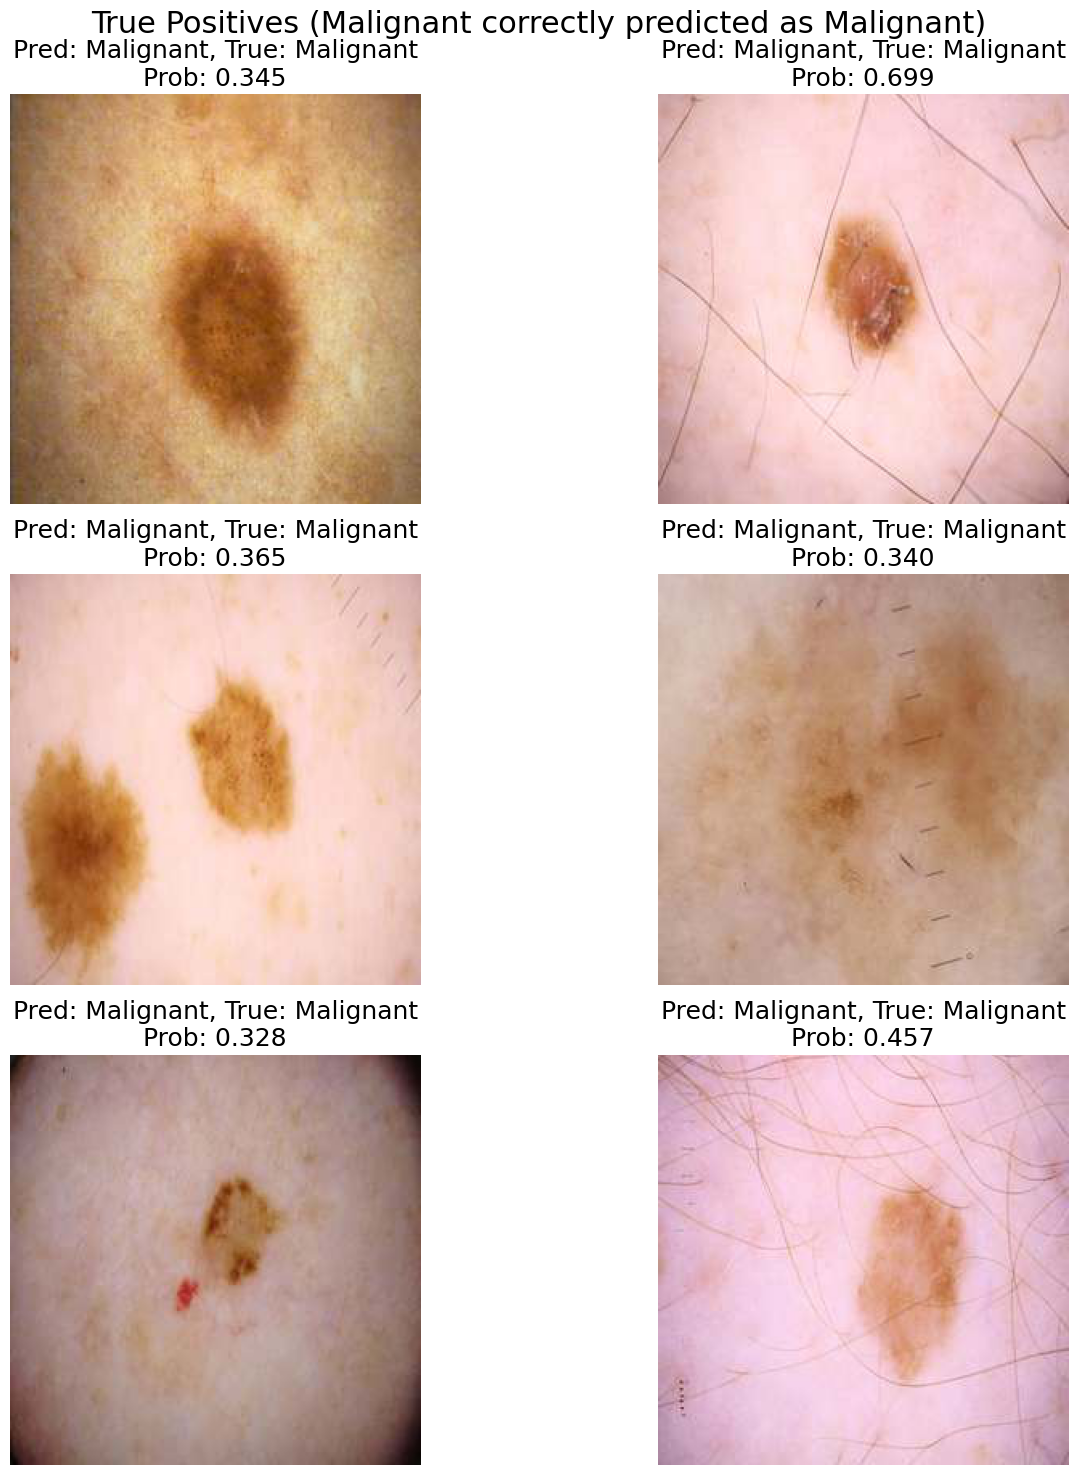

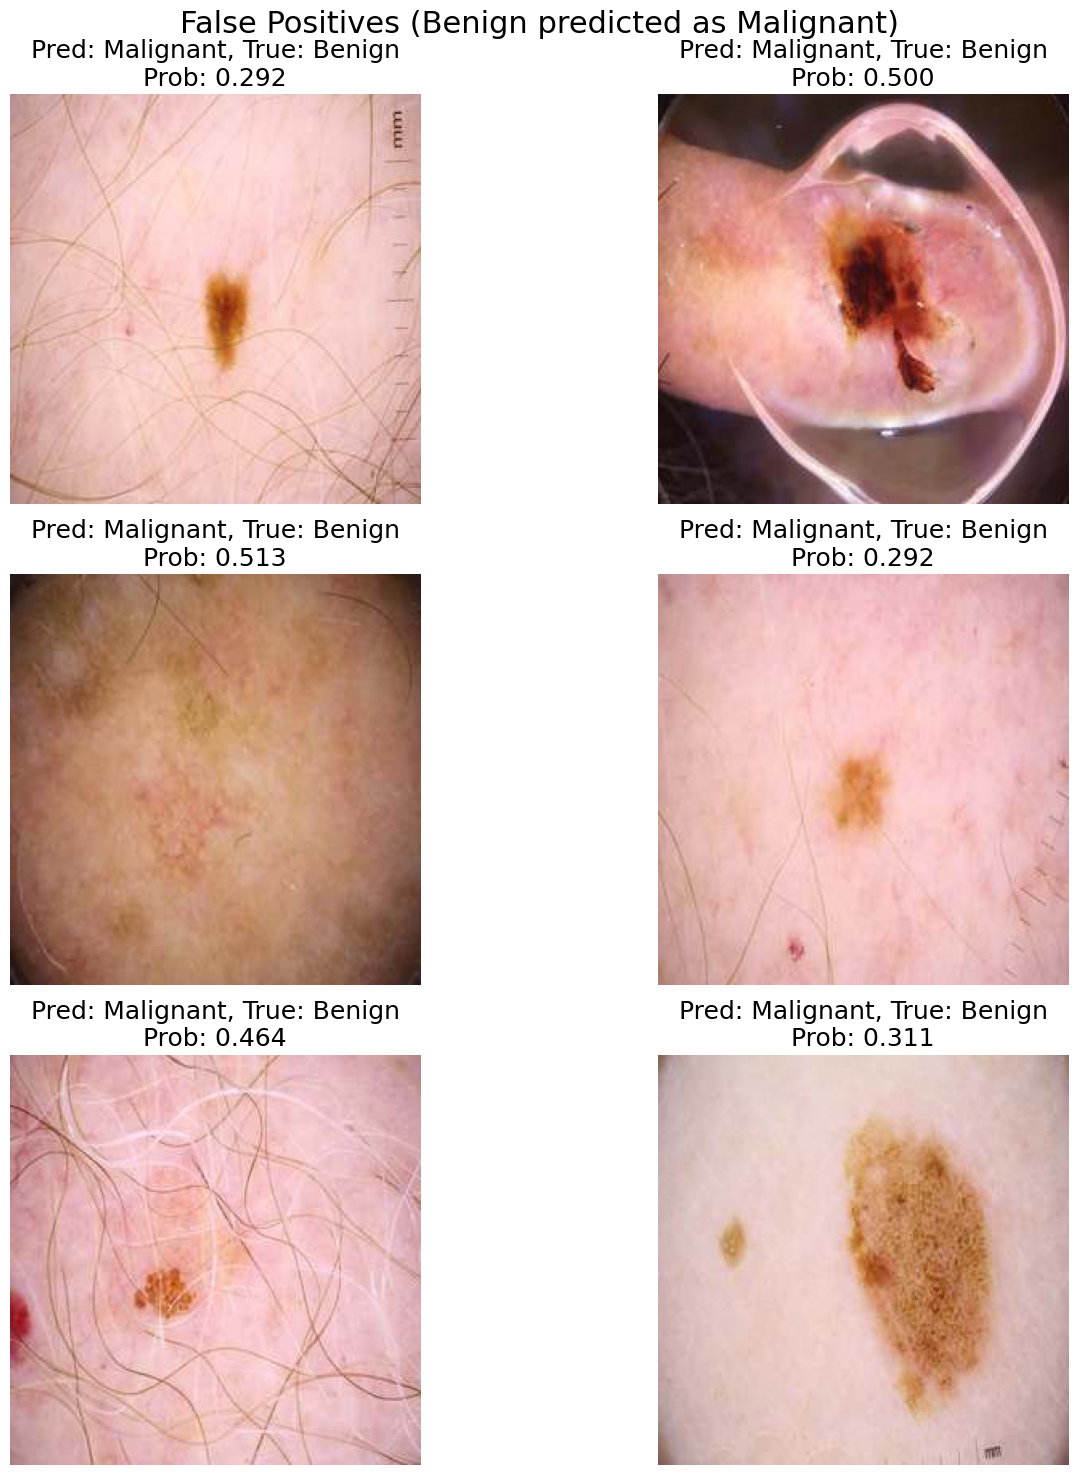

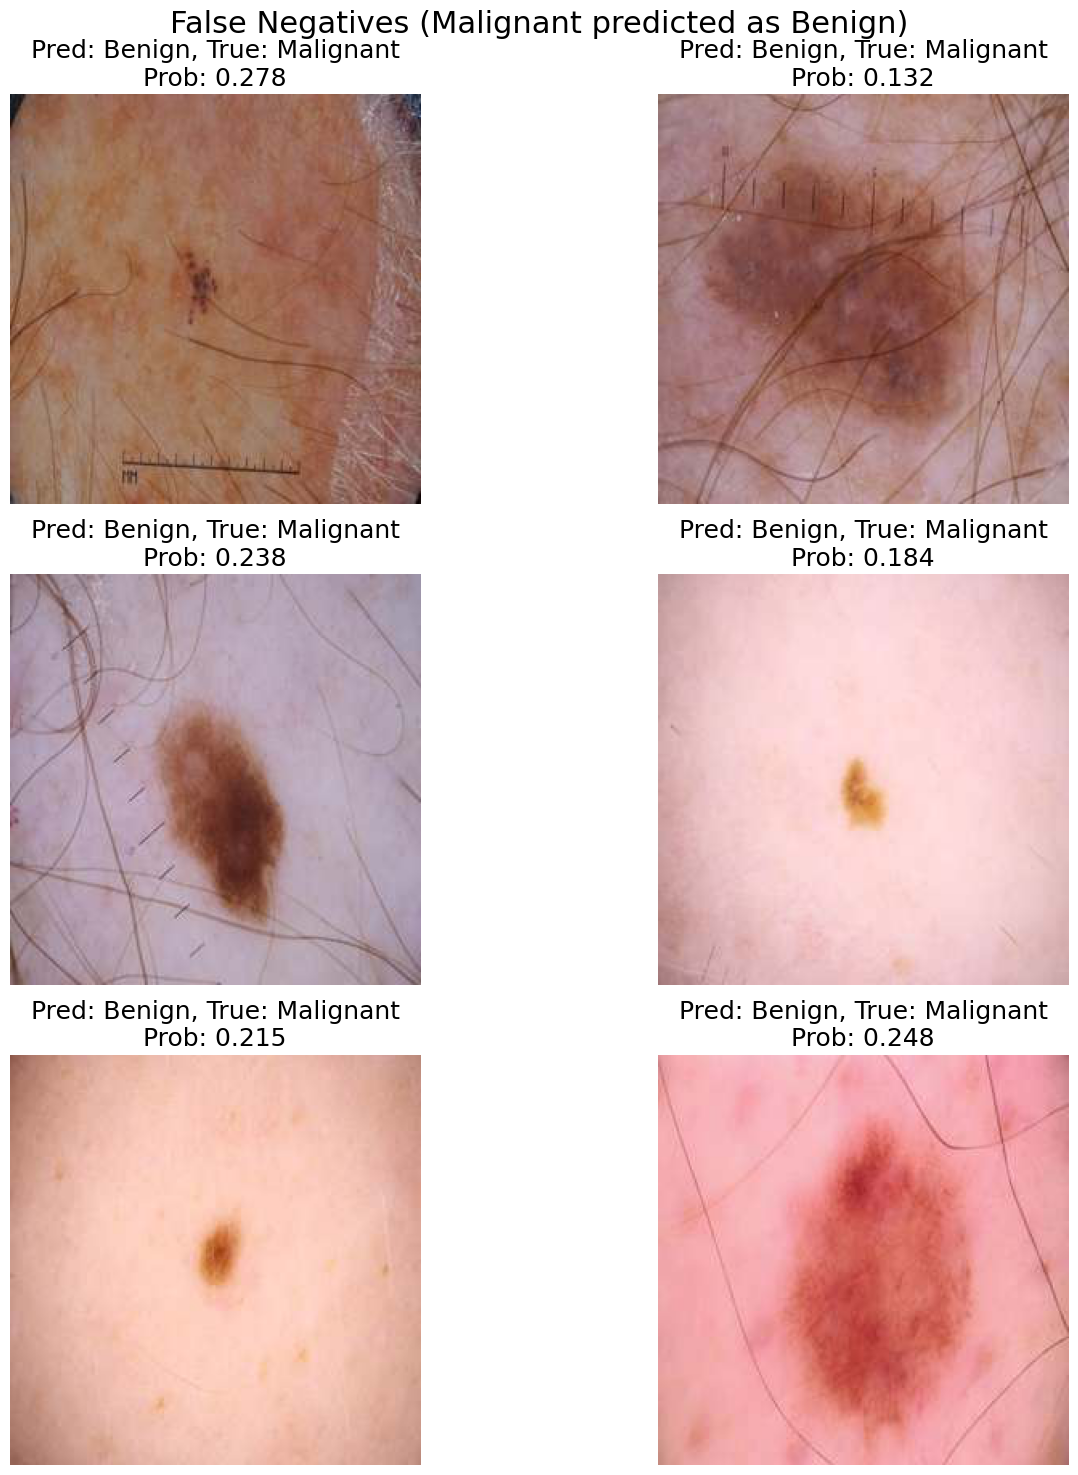

In [38]:
import os
import json
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

import matplotlib.pyplot as plt

# Load the validation results for base_small model
model_name = "base_small"
val_results_file = os.path.join(saved_models_dir, model_name, "val_results.json")

with open(val_results_file, "r") as f:
    val_results = json.load(f)

# Extract probabilities, targets, and image names
probabilities = np.array(val_results["probabilities"])
targets = np.array(val_results["targets"])
image_names = val_data["image_name"].values

# Apply threshold of 0.28
threshold = 0.28
predictions = (probabilities >= threshold).astype(int)

# Find incorrect predictions
incorrect_indices = np.where(predictions != targets)[0]
print(f"Total incorrect predictions with threshold 0.28: {len(incorrect_indices)}")

# Calculate false positives, false negatives, and true positives
false_positives = np.where((predictions == 1) & (targets == 0))[0]
false_negatives = np.where((predictions == 0) & (targets == 1))[0]
true_positives = np.where((predictions == 1) & (targets == 1))[0]
print(f"False positives: {len(false_positives)}")
print(f"False negatives: {len(false_negatives)}")
print(f"True positives: {len(true_positives)}")

# Function to display images
def display_images(indices, predictions, targets, title):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices[:6]):  # Display up to 6 images
        if i >= len(axes):
            break
            
        img_name = image_names[idx]
        img_path = os.path.join(train_dataset_path, img_name + ".jpg")
        
        # Check if file exists, if not, try without appending .jpg
        if not os.path.exists(img_path):
            img_path = os.path.join(train_dataset_path, img_name)
            
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            pred_text = "Malignant" if predictions[idx] == 1 else "Benign"
            true_text = "Malignant" if targets[idx] == 1 else "Benign"
            axes[i].set_title(f"Pred: {pred_text}, True: {true_text}\nProb: {probabilities[idx]:.3f}", fontsize=18)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"Image not found:\n{img_name}", 
                 horizontalalignment='center', verticalalignment='center', fontsize=18)
            axes[i].axis('off')
        
    plt.suptitle(title, fontsize=22)
    plt.tight_layout()
    plt.show()

# Display some true positives (malignant correctly predicted as malignant)
if len(true_positives) > 0:
    display_images(true_positives, predictions, targets, "True Positives (Malignant correctly predicted as Malignant)")

# Display some false positives (benign predicted as malignant)
if len(false_positives) > 0:
    display_images(false_positives, predictions, targets, "False Positives (Benign predicted as Malignant)")

# Display some false negatives (malignant predicted as benign)
if len(false_negatives) > 0:
    display_images(false_negatives, predictions, targets, "False Negatives (Malignant predicted as Benign)")